### AGENDA

1. React Agent (Reasoning and Action Agent)
- Load an LLM ---> bind multiple tools ---> LLM with tool
- query --> LLM with tool --> tool1 or tool2 or tool3 \

    1.1 Tool - Tool is decorator for a function 

```     
                
                query (current weather of Delhi)
                          |
                          |
                         \ / 
                    _____________
                    |           |
                    |   LLM     |
                    _____________
which appropriate    /\  /   \
tool needs           /  /     \
to be called        /  /       \
loops until        /  \/       \/
correct info  _____________  _____________
              |           |  |            |
              |   LLM     |  |     END    |
              _____________  ______________

```

In [ ]:
# API key loading removed for security reasons
import os
# os.getenv("GROQ_API_KEY")

'REDACTED_API_KEY'

In [ ]:
# Environment variable loading removed for security
# from dotenv import load_dotenv
# load_dotenv()
# os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

# To use this notebook, create your own .env file with:
# GROQ_API_KEY=your_api_key_here

In [85]:
model = "deepseek-r1-distill-llama-70b"

In [86]:
from langchain_groq import ChatGroq

llm = ChatGroq(model_name = model)

In [87]:
print(llm.invoke("HI").content)

<think>

</think>

Hello! How can I assist you today? 😊


In [20]:
import operator
from typing import List, Union
from pydantic import BaseModel, Field
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

In [21]:
# Here ```MessagesState``` is a pre-built class available in langgraph module that is used to store the messages in the state.
# ```MessagesState``` is an alternative to the ```Agenstate``` that we created from scratch in the previous class.
# From previous class: 
# class Agentstate(TypedDict):
#    messages: Annotated[Sequence[BaseMessage], operator.add]

def call_model(state: MessagesState):
    # Get the current message from state
    messages = state["messages"]
    print(f"This is my current message: {messages}")
    
    # Convert messages to proper format

    # Creates an empty list to store the properly formatted messages
    formatted_messages = []

    for msg in messages:

        # Checks if the message is already a BaseMessage instance
        # BaseMessage is the parent class for all message types in LangChain (like HumanMessage, AIMessage, SystemMessage, etc.)
        # If it is, we keep it as-is because it's already in the correct format
        # Example: HumanMessage(content="Hello") would pass this check
        if isinstance(msg, BaseMessage):
            formatted_messages.append(msg)

        # Checks if the message is a plain string
        # If it is, wraps it in a HumanMessage object
        # The string becomes the content of the message
        # Example: "Hello" becomes HumanMessage(content="Hello")   
        elif isinstance(msg, str):
            formatted_messages.append(HumanMessage(content=msg))
        
        # Handles any other type of input (numbers, lists, dictionaries, etc.)
        # Converts the input to a string using str()
        # Then wraps it in a HumanMessage
        # Example: 42 becomes HumanMessage(content="42")
        else:
            formatted_messages.append(HumanMessage(content=str(msg)))

    #   BaseMessage
    #    ├── HumanMessage     (for user inputs)
    #    ├── AIMessage        (for AI responses)
    #    ├── SystemMessage    (for system instructions)
    #    └── FunctionMessage  (for function calls/returns)
    
    # Invoke the model with properly formatted messages
    response = llm.invoke(formatted_messages)
    
    return {"messages": [response]}


In [22]:
state = {"messages": ["What is the GDP of the USA?"]}
state = {"messages": ["What is the GDP of the India?"]}

call_model(state)

This is my current message: ['What is the GDP of the India?']


{'messages': [AIMessage(content="<think>\nOkay, so I need to find out what the GDP of India is. I remember that GDP stands for Gross Domestic Product, which is a measure of a country's economic performance. It's the total value of all goods and services produced within a country over a specific time period, usually a year.\n\nFirst, I should consider the source of the information. GDP figures can vary slightly depending on the source, like the World Bank, IMF, or the country's own statistical agencies. For India, the Reserve Bank of India and the National Statistical Office are reliable sources.\n\nI know that GDP can be nominal or PPP (Purchasing Power Parity). Nominal GDP is the total value in current prices, while PPP adjusts for cost of living differences. I think the user is asking for nominal GDP, but I'm not entirely sure. Maybe I should mention both just in case.\n\nI recall that India's economy is one of the largest in the world, so the GDP should be in the trillions of USD. F


#### Creating a Langgraph Workflow

#### 1. Creating object StateGraph

In [23]:
workflow = StateGraph(MessagesState)

In [24]:
workflow.add_node("mybot", call_model)

In [25]:
workflow.add_edge(START, "mybot")

In [26]:
workflow.add_edge("mybot", END)

In [27]:
app = workflow.compile()

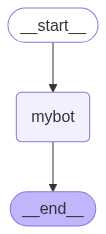

In [28]:
display(Image(app.get_graph().draw_mermaid_png()))

In [29]:
input = {"messages": ["Hi, how are you?"]}

In [30]:
app.invoke(input)

This is my current message: [HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='7308648b-562a-43a1-ad16-a3ce2f14fab1')]


{'messages': [HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='7308648b-562a-43a1-ad16-a3ce2f14fab1'),
  AIMessage(content="<think>\n\n</think>\n\nHi! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.211398017, 'prompt_time': 0.000792646, 'queue_time': 0.055727114, 'total_time': 0.212190663}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--48d27f08-a981-4f49-9799-8fdfb1b1b3fd-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})]}

In [31]:
for output in app.stream(input):
    for key, value in output.items():
        print(f"Output from {key} Node")
        print("________________")
        print(value)
        print("\n")

This is my current message: [HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='0509f68d-1120-4332-9238-24bfe6c1438e')]
Output from mybot Node
________________
{'messages': [AIMessage(content="<think>\n\n</think>\n\nHi! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.205458838, 'prompt_time': 0.000473471, 'queue_time': 0.056371718999999994, 'total_time': 0.205932309}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--3282228d-aac9-4969-adaa-c6b1b19774a5-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})]}




_____________________

#### Binding Tools

In [32]:
@tool
# creating custom tool
def search (query: str):
    
    """This is my custom tool for searching a weather"""

    if "delhi" in query.lower():
        return "the temp is 45 degree and sunny"
    return "the temp is 25 degree and cloudy"

In [33]:
search.invoke("what is the temperature in kashmir")

'the temp is 25 degree and cloudy'

In [34]:
search.invoke("what is the weather in delhi")

'the temp is 45 degree and sunny'

In [35]:
search

StructuredTool(name='search', description='This is my custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x10fd9f100>)

In [36]:

tools = [search]

```llm.bind_tools``` is a method that takes a list of tools and binds them.

In [37]:
llm_with_tool = llm.bind_tools(tools)

In [38]:
response =llm_with_tool.invoke("what is the weather in delhi")

In [39]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '28hbhak6x', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 132, 'total_tokens': 213, 'completion_time': 0.413203683, 'prompt_time': 0.013688257, 'queue_time': 0.058104712999999995, 'total_time': 0.42689194}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--610553e8-b775-4976-83a2-8146f56d9bef-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': '28hbhak6x', 'type': 'tool_call'}], usage_metadata={'input_tokens': 132, 'output_tokens': 81, 'total_tokens': 213})

We see that directly calling the ```llm_with_tool``` does not return any content:

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '3ec8h382z', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 122, 'prompt_tokens': 132, 'total_tokens': 254, 'completion_time': 0.552335418, 'prompt_time': 0.008446532, 'queue_time': 0.056085977, 'total_time': 0.56078195}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2f656fa2-fe95-4696-a445-5d2625006914-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': '3ec8h382z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 132, 'output_tokens': 122, 'total_tokens': 254})


In [40]:
# So check if it is redirecting the tool call or not. Here, it is redirecting the tool call: 'name': 'search'

response.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': '28hbhak6x',
  'type': 'tool_call'}]

Here, this query part will be passed to the tool, and, the tool will generate a response:

[{'name': 'search', \
  'args': {'query': 'weather in Delhi'}, \
  'id': '3ec8h382z', \
  'type': 'tool_call'}] 

#### The workflow needs to be orchestrated via langgraph.

In [41]:
def call_model(state: MessagesState):
    question = state["messages"]
    response = llm_with_tool.invoke(question)
    return {"messages": [response]}

In [42]:
input = {"messages": ["What is the weather in Delhi?"]}

In [43]:
response = call_model(input)

In [44]:
response["messages"][-1].content

''

In [45]:
response["messages"][-1].tool_calls

[{'name': 'search',
  'args': {'query': 'Delhi weather'},
  'id': 'syard0btj',
  'type': 'tool_call'}]

Now using this particular logic ```response["messages"][-1].tool_calls``` we have to fetch the details of the tool, i.e., which tool is being called. And we will define that in the ```router``` function.

And based on the detail of the tool call we will segregate and delegate the calls to its respective tools.


In [46]:
def router_function(state: MessagesState):
    message = state["messages"]
    last_message = message[-1]
    if last_message.tool_calls:
        return "mytools"
    return END

In [47]:
tools

[StructuredTool(name='search', description='This is my custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x10fd9f100>)]

If we want to fit this ```tools``` into the langgraph workflow, we need to convert it into a node. \
We use the pre-built method ```ToolNode``` available in langgraph.

In [48]:
tool_node = ToolNode(tools)

In [49]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'search': StructuredTool(name='search', description='This is my custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x10fd9f100>)}, tool_to_state_args={'search': {}}, tool_to_store_arg={'search': None}, handle_tool_errors=True, messages_key='messages')

In [50]:
workflow2 = StateGraph(MessagesState)

In [51]:
workflow2.add_node("llmwithtool", call_model)

workflow2.add_node("mytools", tool_node)

In [52]:
workflow2.add_edge(START, "llmwithtool")

workflow2.add_conditional_edges("llmwithtool", router_function, {"mytools": "mytools", END: END})

# Add edge from mytools back to llmwithtool to continue the conversation
# workflow2.add_edge("mytools", "llmwithtool")

In [39]:
app2 = workflow2.compile()

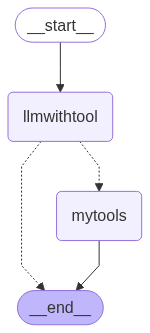

In [40]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

#### Flow of the architecture:

Step 1: We give an input to the ```llmwithtool``` which decides if we need to call llmwithtool or not \
Step 2: If the input is related to the tool, it redirects to ```mytools``` and generates the process \
Step 3: If it is not related to the toolthen it generates the standard LLM output.

In [41]:
app2.invoke({"messages": ["What is the weather is Bengaluru?"]})

{'messages': [HumanMessage(content='What is the weather is Bengaluru?', additional_kwargs={}, response_metadata={}, id='23bb9538-4bd3-4c2b-ab0f-6e43d9e36ccd'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'bkjcqr968', 'function': {'arguments': '{"query":"Bengaluru"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 104, 'prompt_tokens': 133, 'total_tokens': 237, 'completion_time': 0.475442703, 'prompt_time': 0.009076811, 'queue_time': 0.056913279, 'total_time': 0.484519514}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--23e1f50e-adb4-445e-805d-a946f772338b-0', tool_calls=[{'name': 'search', 'args': {'query': 'Bengaluru'}, 'id': 'bkjcqr968', 'type': 'tool_call'}], usage_metadata={'input_tokens': 133, 'output_tokens': 104, 'total_tokens': 237}),
  ToolMessage(content='the temp is 25 degree and cloudy', name='search', id='

 _____________
 
 ```                              
                                _____________
                                |           |
                                | __start__ |                                   
                                _____________                       
                                      |
                                      |
                                      |
                                     \ /
                                ________________
                                |               |
                                | llmwithtool   |
                                _________________
                                    /       \
                                   /         \   
                                  /           \
                                 |          tools
                                 |              |
                                 |             \ /
                                 |          _____________
                                 |          |           |
                                 |          |  mytools  |
                                 |          _____________
                                 |              |
                                 |              |
                                 \              /
                                  \            /
                                  \/          \/ 
                                    _____________
                                    |           |
                                    | __start__ |
                                    _____________



          _____________________________________________________
          |                                                   |
          |                                                  \ /
Input -> LLM -> ```<thinking>``` -> ```<action>``` -> ```<observation>``` -> Output
         / \                                                  |
          |                                                   |
          -----------------------------------------------------
```



_______

Question: Can you tell me about the Zerodha stock price and add a 100 in that stock price?

tool1 -> fetches the zerodha stock price from e.g.: Yahoo API

Let's say the zerodha stock price is 5000 and w ehav eto return 6000 (5000 + 1000)


These type of scenarios will be taken care by the Agentic Flow.

We understood the tool calling, now we will work on React Agents.

React -  Reasoning and Action

Reasoning is related to the LLM and Action is tool calling. (LLM + Multiple tool calling)


For instance,

1. Tool => YahooAPI, Add, Summation \
llm = llm.bind_tools[Yahoo, Add, Sum] \
llm.invoke("What is the stock price of Zerodha? Add 1000 in the final stock price.")
```
            <start>
                |
               LLM   (What is the stock price of Zerodha? Add 1000 in the final stock price.)
               / \  \
              /   \  \
             /     \ToolNode  
            /      <Yahoo, Add, Multiply>
           |
           |
           END

```

Here LLM is acting as a validator.  ```LLM``` <-- binds tool (```<stock price>```) (Add 1000 to the given stcok price)

For the first part of the question "Zerodha stock price" it calls the ```Yahoo``` tool. here, 5000, and calls back the ```LLM``` to validate the information.

Next, to tackle the addition of 1000, LLM calls the tool ```Add```, 5000+1000 = 6000, and calls the ```LLM``` tool back to validate.

Note:-  It is crucial to remember that we are catching all the information in the form of ```state```, a list of messages.

In [54]:
app3 = workflow2.add_edge("mytools", "llmwithtool")

In [55]:
app3 = workflow2.compile()

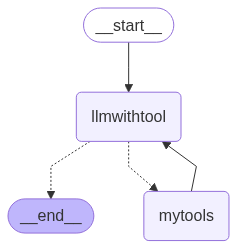

In [56]:
from IPython.display import Image, display
display(Image(app3.get_graph().draw_mermaid_png()))

In [57]:
for output in app3.stream({"messages": ["What is weather in Delhi?"]}):
    for key, value in output.items():
        print(f"Output from {key} Node")
        print("________________")
        print(value)
        print("\n")

Output from llmwithtool Node
________________
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'cvdvfv1df', 'function': {'arguments': '{"query":"Delhi weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 124, 'prompt_tokens': 131, 'total_tokens': 255, 'completion_time': 0.525414454, 'prompt_time': 0.01009867, 'queue_time': 0.05674349599999999, 'total_time': 0.535513124}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--50c6cf8c-0e0c-40f8-a8a8-68d33799858a-0', tool_calls=[{'name': 'search', 'args': {'query': 'Delhi weather'}, 'id': 'cvdvfv1df', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 124, 'total_tokens': 255})]}


Output from mytools Node
________________
{'messages': [ToolMessage(content='the temp is 45 degree and sunny', name='search', id='bae8f461-db08-4525-8c3f-7daa736

____________
#### How to configure memory in the langraph?

In [58]:
from langgraph.checkpoint.memory import MemorySaver

In [59]:
memory = MemorySaver()

In [60]:
workflow3 = StateGraph(MessagesState)

workflow3.add_node("llmwithtool", call_model)

workflow3.add_node("mytools", tool_node)

workflow3.add_edge(START, "llmwithtool")

workflow3.add_conditional_edges("llmwithtool", router_function, {"mytools": "mytools", END: END})

# Add edge from mytools back to llmwithtool to continue the conversation
workflow3.add_edge("mytools", "llmwithtool")


In [62]:
app4 = workflow3.compile(checkpointer=memory)

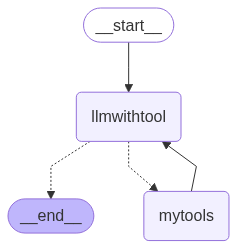

In [63]:
from IPython.display import Image, display
display(Image(app4.get_graph().draw_mermaid_png()))

In [64]:
config = {"configurable": {"thread_id": "1"}}

In [69]:
events = app4.stream({"messages": ["What is weather in Delhi?"]}, config=config, stream_mode="values")

# using the method ```config``` we will be able to sustain the entire conversation wrt the specific thread.

In [70]:
# the method ```stream``` is loading the entire output in a memory and is processing it in batches.

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is weather in Delhi?
================================== Ai Message ==================================
Tool Calls:
  search (804xzty1c)
 Call ID: 804xzty1c
  Args:
    query: weather in Delhi
================================= Tool Message =================================
Name: search

the temp is 45 degree and sunny
================================== Ai Message ==================================

The current weather in Delhi is 45 degrees and sunny. Is there anything else you'd like to know about the weather?


In [71]:
events = app4.stream({"messages": ["What is weather in Indore?"]}, config=config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is weather in Indore?
================================== Ai Message ==================================
Tool Calls:
  search (dnxhyt0ps)
 Call ID: dnxhyt0ps
  Args:
    query: weather in Indore
================================= Tool Message =================================
Name: search

the temp is 25 degree and cloudy
================================== Ai Message ==================================

The current weather in Indore is 25 degrees and cloudy. Is there anything else you'd like to know about the weather?


In [74]:
config

{'configurable': {'thread_id': '1'}}

In [75]:
memory.get(config)

{'v': 4,
 'ts': '2025-07-04T17:02:16.850922+00:00',
 'id': '1f058f8a-39bb-6464-800a-dfd8ed4e1721',
 'channel_versions': {'__start__': '00000000000000000000000000000009.0.22731667567174618',
  'messages': '00000000000000000000000000000012.0.8989221631125421',
  'branch:to:llmwithtool': '00000000000000000000000000000012.0.8989221631125421',
  'branch:to:mytools': '00000000000000000000000000000011.0.7447442469933642'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000008.0.7204475941381934'},
  'llmwithtool': {'branch:to:llmwithtool': '00000000000000000000000000000011.0.7447442469933642'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000010.0.4871261554377919'}},
 'channel_values': {'messages': [HumanMessage(content='What is weather in Delhi?', additional_kwargs={}, response_metadata={}, id='b4602591-047b-4f10-97fa-9dd3e14531ab'),
   HumanMessage(content='What is weather in Delhi?', additional_kwargs={}, response_metadata={}, 

In [77]:
events = app4.stream({"messages": ["What is weather in Indore?"]}, config=config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is weather in Indore?
================================== Ai Message ==================================

The current weather in Indore is 25 degrees and cloudy. Is there anything else you'd like to know about the weather?


What we see in the final output is that it is not calling any tool, which is possilbe due to the memory method in use.

In [78]:
memory.get(config)

{'v': 4,
 'ts': '2025-07-04T17:07:40.268572+00:00',
 'id': '1f058f96-4615-624e-8027-3eadb2024b82',
 'channel_versions': {'__start__': '00000000000000000000000000000040.0.39640020177915447',
  'messages': '00000000000000000000000000000041.0.6036069534051846',
  'branch:to:llmwithtool': '00000000000000000000000000000041.0.6036069534051846',
  'branch:to:mytools': '00000000000000000000000000000038.0.12302345090759481'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000039.0.9984214216826777'},
  'llmwithtool': {'branch:to:llmwithtool': '00000000000000000000000000000040.0.39640020177915447'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000037.0.7048806696849181'}},
 'channel_values': {'messages': [HumanMessage(content='What is weather in Delhi?', additional_kwargs={}, response_metadata={}, id='b4602591-047b-4f10-97fa-9dd3e14531ab'),
   HumanMessage(content='What is weather in Delhi?', additional_kwargs={}, response_metadata={}

We see the information got appended in the memory.